In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = nn.Sequential(
    # какие-нибудь nn.Linear и нелинейности
    # ...
    nn.Linear(28 * 28, 500),
    nn.ReLU(),
    nn.Dropout(),

    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Dropout(),

    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Dropout(),

    nn.Linear(100, 10),
   
    

    nn.LogSoftmax(dim=1)
)

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=500, out_features=200, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=200, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=100, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
)

In [ ]:
def accuracy(model, val):
    model.eval()
    total = 0
    correct = 0
    for X, y in val:
        X = X.view(-1, 784)

        X = X.to(device)
        y = y.to(device)

        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    model.train()
    return correct / total

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
criterion = criterion.to(device)


0.9813166666666666 0.9719
0.9827833333333333 0.974
0.9836 0.9741
0.9842 0.9741
0.9853166666666666 0.9739
0.98615 0.9745
0.9869166666666667 0.975
0.9874 0.9749
0.9874666666666667 0.9754
0.9886666666666667 0.9762
0.9884333333333334 0.9751
0.9885666666666667 0.9754
0.9891833333333333 0.9755
0.99035 0.9768
0.9904 0.9768
0.9909166666666667 0.9777
0.9907166666666667 0.977
0.9916833333333334 0.978
0.9920833333333333 0.9765
0.99185 0.977
0.9931666666666666 0.9774
0.9925333333333334 0.9767
0.9932833333333333 0.9788
0.9929666666666667 0.9778
0.9932666666666666 0.9778
0.9939833333333333 0.9782
0.9936833333333334 0.9774
0.9939833333333333 0.9786
0.9938666666666667 0.9782
0.99405 0.9774
0.9939166666666667 0.978
0.9947 0.978
0.9953 0.9787
0.9945666666666667 0.9801
0.9949833333333333 0.9784
0.9954666666666667 0.9778
0.99525 0.9796
0.9954833333333334 0.978
0.9955333333333334 0.9792
0.9955166666666667 0.9788
0.9953333333333333 0.9789
0.9958333333333333 0.9793
0.9954666666666667 0.9791
0.995566666666666

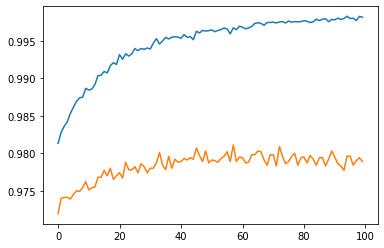

In [ ]:
best_model = dict()
best_accuracy = 0
train_losses = []
train_acc, val_acc = [], []
for epoch in range(100):
    for X, y in train:
        X = X.view(-1, 784)  # разгладим картинку в вектор
        
        optimizer.zero_grad()

        X = X.to(device)
        y = y.to(device)

        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        train_losses.append(loss.item())
        # как думаете, зачем нужен .item()?
        # подсказка: лосс хранит информацию о своей истории
        # попробуйте убрать .item() и посмотреть на расход памяти
        
        optimizer.step()
    train_accuracy, val_accuracy = accuracy(model, train), accuracy(model, val)
    if val_accuracy > best_accuracy:
      best_model = model.state_dict()
      best_accuracy = val_accuracy

    print(train_accuracy, val_accuracy)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
        
plt.plot(train_acc)
plt.plot(val_acc)
plt.show()

In [ ]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [ ]:
accuracy(model, val)

0.9789

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            # мы хотим перевести картинку в какое-нибудь X-мерное пространство
            nn.Linear(28 * 28, 500),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(100, 10),
        )
        
        self.decode = nn.Sequential(
            # а теперь наоборот - из Х-мерного в картинку
            nn.Linear(10, 10 * 10),
            nn.ReLU(),

            nn.Linear(10 * 10, 200),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(200, 28 * 28),
            nn.Sigmoid()
            # картинки -- это тензоры со значениями от 0 до 1
            # нет особого смысла выводить что-то не из этого промежутка
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
model = model.to(device)

criterion = torch.nn.MSELoss()
criterion = criterion.to(device)
#                    ^ попробуйте также другие меры разности (например, абсолютную ошибку)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        #     ^ лэйблы нам не нужны
        data = data.view(-1, 784)
        data = data.to(device)

        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0579
epoch 1, loss 0.0429
epoch 2, loss 0.0404
epoch 3, loss 0.0395
epoch 4, loss 0.0389
epoch 5, loss 0.0385
epoch 6, loss 0.0382
epoch 7, loss 0.0381
epoch 8, loss 0.0378
epoch 9, loss 0.0376


In [ ]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import numpy

In [ ]:
def get(x):
    return train.dataset[x][0].view(1, 784).to(device)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    
    latent = [model.encode(get(k)).data for k in inputs]
    
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).cpu().data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

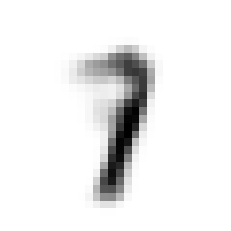

In [ ]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)

# Визуализация

In [ ]:
import seaborn as sns

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            # мы хотим перевести картинку в какое-нибудь X-мерное пространство
            nn.Linear(28 * 28, 500),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),

            nn.Linear(10, 10 * 10),
            nn.ReLU(),

            nn.Linear(10 * 10, 200),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(200, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))
    

model = Autoencoder()
model = model.to(device)

criterion = torch.nn.MSELoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        
        data = data.view(-1, 784)
        data = data.to(device)

        optimizer.zero_grad()
        
        reduce = model(data)
        loss = criterion(data, reduce)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0606
epoch 1, loss 0.0492
epoch 2, loss 0.0470
epoch 3, loss 0.0460
epoch 4, loss 0.0454
epoch 5, loss 0.0451
epoch 6, loss 0.0447
epoch 7, loss 0.0445
epoch 8, loss 0.0443
epoch 9, loss 0.0442


Text(0.5, 1.0, 'MNIST visualization')

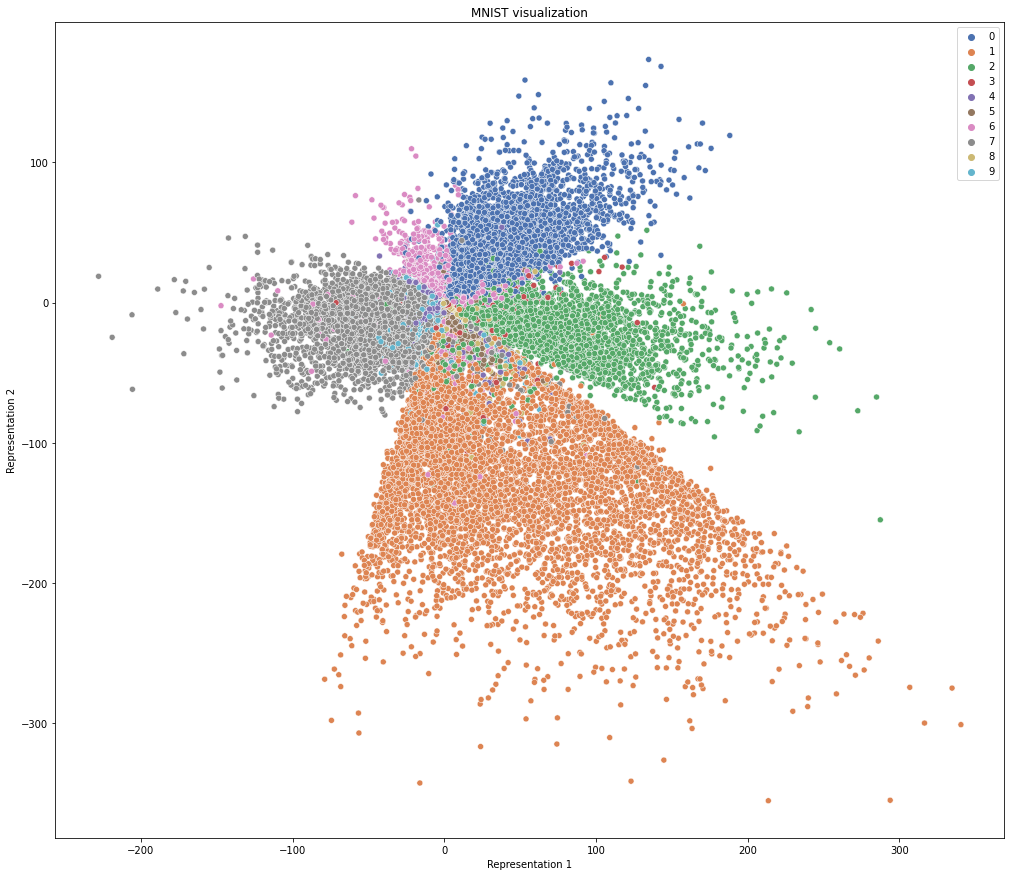

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

plt.figure(figsize=(17, 15))
i = 0
show = 'full'
for data, labels in train:
  a = model.encode(data.view(-1, 784).to(device)).cpu().data
  if i > 0:
    show = False
  sns.scatterplot(a[:,0], a[:, 1], hue=labels, palette='deep', alpha=1, legend=show)
  i = 1
  
plt.xlabel('Representation 1')
plt.ylabel('Representation 2')
plt.title('MNIST visualization')

# Домашнее задание

* Получить точность 97.5% на валидации MNIST.
* Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).
* Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

### *Свёртки

Если у вас останется время, вы можете улучшить результаты, используя свёртки.

О свёрточных сетях в деталях вы узнаете на следующем занятии, а пока что вы можете использовать `nn.Conv2d`, `nn.MaxPool2d`, и `nn.ConvTranspose2d` просто как более продвинутые слои для классификатора и автоэнкодера, даже не особо понимая, как они внутри работают.

Основная задача «нейроинженеров» — придумать, как выглядело бы решение этой задачи на уровне программы с неизвестными параметрами, и подбирать соответствующие архитектуры. [Эксперименты с дропаутом](https://arxiv.org/pdf/1701.05369.pdf) показывают, что в Linear примерно 99% весов на самом деле можно выкинуть. Логично, что в оптимальной архитектуре не должно быть бесполезных весов — лишние параметры всегда ведут к переобучению. В случае с картинками решение в том, чтобы использовать информацию о расположении пикселей относительно друг друга, чтобы создать слой, который смотрит на более релевантные фичи. Мотивация заключается примерно в этом, подробнее — через неделю.

<img width='250px' src='https://cdn-images-1.medium.com/max/1600/0*iqNdZWyNeCr5tCkc.'>